Data preparation

random_state=1
url= 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
#train/validation/test with 60%/20%/20%
if there are missing values:
    For caterogiral features, replace them with 'NA'
    For numerical features, replace with with 0.0

classification: converted variable


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
url= 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(url)

df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
df.columns= df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for column in categorical_columns:
    df[column] = df[column].str.lower().str.replace(' ', '_')
    #df[column].fillna('NA', inplace=True)
    df.fillna({column:'NA'}, inplace=True)


In [5]:
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

In [6]:
df.fillna({'annual_income':0}, inplace=True)
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train,test_size=0.25, random_state=42) #20% of the orignal df

df_train= df_train.reset_index(drop= True)
df_val= df_val.reset_index(drop= True)
df_test= df_test.reset_index(drop= True)

y_train=df_train.converted.values
y_val=df_val.converted.values
y_test=df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [8]:
numerical_columns = list(df_train.dtypes[df_train.dtypes != 'object'].index)

In [9]:
from sklearn.feature_extraction import DictVectorizer
dv= DictVectorizer(sparse=False)
train_dict= df_train[categorical_columns + numerical_columns].to_dict(orient= 'records')
X_train= dv.fit_transform(train_dict)

val_dict=df_val[categorical_columns + numerical_columns].to_dict(orient= 'records')
X_val= dv.fit_transform(val_dict)

Question 1: ROC AUC feature importance

In [10]:
from sklearn.metrics import roc_auc_score

numerical_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for var in numerical_vars:
    score = df_train[var]
   
    auc = roc_auc_score(y_train, score)
    
    # if AUC less than 0.5, use negative
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
    
    auc_scores[var] = auc

# Who is the best
best_var = max(auc_scores, key=auc_scores.get)
print("Variable with highest AUC:", best_var)
print("AUC value:", auc_scores[best_var])


Variable with highest AUC: number_of_courses_viewed
AUC value: 0.7550107522101766


Question 2: Training the model

In [11]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [12]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [13]:
dv, model = train(df_train, y_train, C=1.0)

In [14]:

y_pred = predict(df_val, dv, model)

In [15]:
auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

0.855

Question 3: Precision and Recall

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


[0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5582191780821918, 0.5582191780821918, 0.5601374570446735, 0.5620689655172414, 0.5620689655172414, 0.5620689655172414, 0.5620689655172414, 0.5620689655172414, 0.5640138408304498, 0.5640138408304498, 0.5679442508710801, 0.5699300699300699, 0.5699300699300699, 0.5780141843971631, 0.5800711743772242, 0.5827338129496403, 0.5869565217391305, 0.5897435897435898, 0.5947955390334573, 0.5947955390334573, 0.599250936329588, 0.6083650190114068, 0.61003861003861, 0.6205533596837944, 0.6305220883534136, 0.6356275303643725, 0.639344262295082, 0.6527196652719666, 0.6540084388185654, 0.6

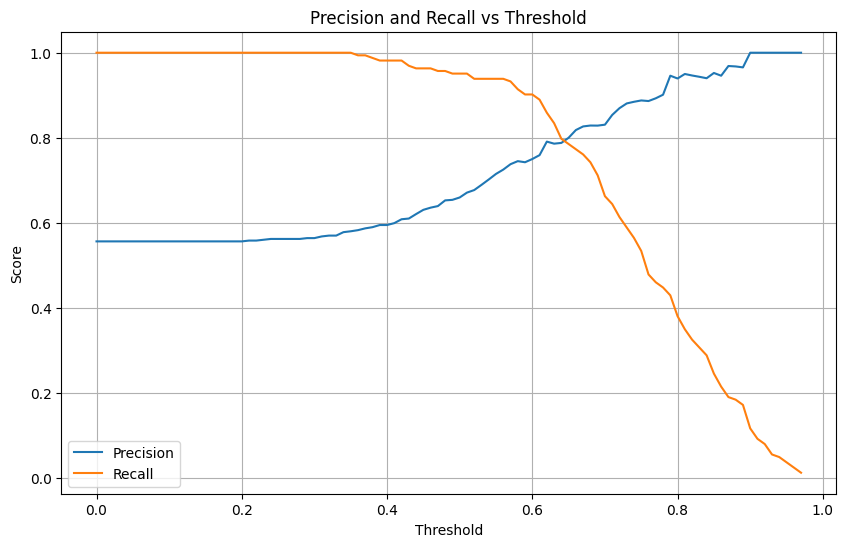

Precision ≈ Recall at threshold ≈ 0.64


In [16]:
from sklearn.metrics import precision_score, recall_score
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
valid_thresholds = []
print(thresholds)

for t in thresholds:
    y_pred_bin = (y_pred >= t).astype(int)

    if y_pred_bin.sum() == 0:
        continue


    precisions.append(precision_score(y_val, y_pred_bin))
    recalls.append(recall_score(y_val, y_pred_bin))
    valid_thresholds.append(t)
print(precisions, recalls)

plt.figure(figsize=(10, 6))
plt.plot(valid_thresholds, precisions, label='Precision')
plt.plot(valid_thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Hol metszik egymást?
diffs = np.abs(np.array(precisions) - np.array(recalls))
intersection_threshold = valid_thresholds[np.argmin(diffs)]
print(f"Precision ≈ Recall at threshold ≈ {intersection_threshold:.2f}")

Question 4: F1 score

In [17]:
from sklearn.metrics import precision_score, recall_score
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
valid_thresholds = []
f1 = []

for t in thresholds:
    y_pred_bin = (y_pred >= t).astype(int)

    if y_pred_bin.sum() == 0:
        continue
    p= precision_score(y_val, y_pred_bin)
    r = recall_score(y_val, y_pred_bin)
    f1_value = 2*(p*r/(p+r))
    f1.append(f1_value)
    precisions.append(p)
    recalls.append(r)
    valid_thresholds.append(t)
print(precisions, recalls)
print(f1)
print(max(f1))


[0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5563139931740614, 0.5582191780821918, 0.5582191780821918, 0.5601374570446735, 0.5620689655172414, 0.5620689655172414, 0.5620689655172414, 0.5620689655172414, 0.5620689655172414, 0.5640138408304498, 0.5640138408304498, 0.5679442508710801, 0.5699300699300699, 0.5699300699300699, 0.5780141843971631, 0.5800711743772242, 0.5827338129496403, 0.5869565217391305, 0.5897435897435898, 0.5947955390334573, 0.5947955390334573, 0.599250936329588, 0.6083650190114068, 0.61003861003861, 0.6205533596837944, 0.6305220883534136, 0.6356275303643725, 0.639344262295082, 0.6527196652719666, 0.6540084388185654, 0.6

Question 5: 5-Fold CV % Question 6: several c

In [20]:

from sklearn.model_selection import KFold
from tqdm.auto import tqdm


n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))






  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.540 +- 0.030
C=0.001 0.860 +- 0.038
C=1 0.827 +- 0.035
